# Resumen

Este colab muestra unos pasos para usar DeepLab para hacer segmentación semántica en una imagen de ejemplo. La salida esperada son rótulos semánticos superpuestos sobre una imagen de ejemplo.


# Intrucciones
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Usar una TPU gratis</h3>

   1. En el menú princpial, cliquear Runtime seleccionar **Change runtime type**. Elegir "TPU".
   1. Cliquear Runtime de nuevo y seleccionar **Runtime > Run All**.

## Importación de librerías

In [ ]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


## Importación de funciones de ayuda
Estas funciones ayudan a realizar las siguientes tareas:

* Cargar la última versión de el modelo DeepLab pre entrenado
* Cargar los mapas de colores del dataset PASCAL VOC
* Agregar colores a los rótulos
* Visualizar una imagen superponiendo colores sobre las varias regiones

In [ ]:
class DeepLabModel(object):
  """Clase para cargar el modelo de deeplab y hacer inferencia"""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Crea y carga el modelo de deeplab pre entrenado"""
    self.graph = tf.Graph()

    graph_def = None
    # Extraer el grafo congelado del archivo tar
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('No es posible hallar el grafo de inferencia en el archivo tar')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Corre inferencia en una imagen

    Args:
      image: Objeto PIL.Image, imagen cruda de entrada.

    Retorna:
      resized_image: imagen RGB re escalada.
      seg_map: mapa de segmentación de `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Crea un mapa de color de rótulos usado en el benchmark de segmentación de in PASCAL VOC.

  Retorna:
    Un mapa de color para visualizar la segmentación.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Le agrega color especificado por el mapa de colores a rótulo del dataset.

  Args:
    label: Un array 2D de tipo entero, con las clases de la segmentación.

  Retorna:
    result: Un array 2D de tipo flotante. Cada elemento del arrya es el color indexado
    por el correspondiente elemento del rótulo de entrada al mapa de colores de PASCAL.

  """
  if label.ndim != 2:
    raise ValueError('Esperado: rótulos de entrada 2-D')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('valor del rótulo demasiado alto')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualiza la imagen de entrada y el mapa de segmentación con colores superpuesto."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

**bold text**## Seleccionar un modelo pre-entrenado
Se entrenó deeplab con varios backboes.Seleccionar uno de la lista MODEL_NAME.

In [ ]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Correr en imágenes de ejemplo:

Elegir una imagen de ejemplo o pegar el URL de una imagen para hacer inferencia.


corriendo deeplab sobre la imagen https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg...


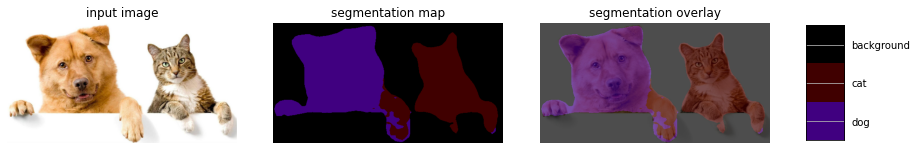

In [ ]:

SAMPLE_IMAGE = 'image2'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Hace inferencia con el modelo DeepLab y visualiza resultado."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('No se puede recuperar la imagen. Chequear el URL: ' + url)
    return

  print('corriendo deeplab sobre la imagen %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)